In [1]:
import requests
import re
import nltk
import pymorphy2

from bs4 import BeautifulSoup
from omegaconf import OmegaConf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm

from parser.parse import Parser
from razdel import tokenize
import numpy as np

In [2]:
args = OmegaConf.load('default.yaml')
html = requests.get(args.istina_people).text
parser = Parser()
reference = parser.istina_parser(html)
vocabulary = parser.get_vocab(reference['publishes'] + reference['place'] + 
                              reference['coauthors'] + args.name.split())

In [3]:
vocabulary = list(vocabulary)
corpus = []
relevant = []
actual_news = []
args = OmegaConf.load('default.yaml')
parser = Parser()
for item in tqdm(args.news):
    html = requests.get(item[0]).text
    text = parser.common_parser(html)
    if len(text):
        actual_news.append(item[0])
        relevant.append(item[1])
        corpus.append(text)
        vocabulary.extend(parser.get_vocab(list((i.text for i in tokenize(text)))))
vocabulary = list(set(vocabulary))

  0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
args

{'name': 'Маслов Алексей Александрович', 'istina_people': 'https://istina.msu.ru/profile/Amaslov/', 'news': [['https://lenta.ru/news/2022/07/02/masloved/', 0], ['https://msk1.ru/text/world/2022/10/11/71727275/', 0], ['https://newizv-ru.turbopages.org/newizv.ru/s/news/incident/26-08-2021/smi-millioner-iz-truschob-artem-maslov-prigovoren-k-10-godam-v-oae', 0], ['https://www.rbc.ru/rbcfreenews/61b60da39a794770a69643ea', 0], ['https://lenta.ru/news/2019/01/21/bureya/', 0], ['https://lenta.ru/news/2022/05/26/maslov/', 1], ['https://lenta.ru/news/2022/10/11/taivan/', 1], ['https://lenta.ru/news/2022/05/26/maslov/', 1], ['https://mir24-tv.turbopages.org/mir24.tv/s/news/16527090/professor-mgu-obyasnil-pochemu-svmda-stanovitsya-centrom-prinyatiya-reshenii', 1]]}

### TF-IDF = TF(t,d) $\times$ IDF(t)
* t - term 
* d - document 
* TF(t,d) - term frequency - number of times term t appears in document d
* IDF(t) - inverse document frequency    IDF(t) $:= \log(\dfrac{1 + n}{1 + DF(t)} + 1)$
* DF(t) - the number of documents in the document set that contain the term t

### BM25 
is a bag-of-words retrieval function that rocks a set of documents based on the query terms appearing in each document, regardless of their proximity within the document.

BM25 score (score) of document D based on (key-words) query Q

$score(D, Q) := \sum_{i=1}^n IDF(q_i) \dfrac{f(q_i, D)(k_1+1)}{f(q_i, D)+k_1(1-b+b\frac{|D|}{avgdl})}$


* __avgdl__ - is the average document length in the text collection from which documents are drawn
* $f(q_i, D)$ - is the number of times that $q_{i}$ occurs in the document $D$
* $k_{1}$, $b$ are free parameters, usually chosen, in absence of an advanced optimization, as $k_{1}\in [1.2,2.0]$ and $b = 0.75$.

* $IDF(q_i) = \ln(\dfrac{N-n(q_i)+0.5}{n(q_i)+0.5}+1)$
* N is the total number of documents in the collection, 
* $n(q_i)$ is the number of documents containing $q_{i}$.

In [5]:
vectorizer = TfidfVectorizer(vocabulary = vocabulary)
X = vectorizer.fit_transform(corpus)

ans = vectorizer.transform([" ".join(reference['publishes']), " ".join(reference['place']), 
                            " ".join(reference['coauthors']), " ".join(args.name.split())])
tfidf_score = ans*X.transpose().toarray()

In [6]:
from rank_bm25 import BM25Okapi

tokenized_corpus = [parser.get_vocab(list((i.text for i in tokenize(doc)))) for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)
bm25_score = []

for doc in [" ".join(reference['publishes']), " ".join(reference['place']), 
             " ".join(reference['coauthors']), " ".join(args.name.split())]:
    
    bm25_score.append(bm25.get_scores(parser.get_vocab(list((i.text for i in tokenize(doc))))))

In [7]:
relevant, len(corpus), len(tokenized_corpus)

([0, 0, 0, 0, 0, 1, 1, 1], 8, 8)

In [8]:
tfidf_score

array([[0.        , 0.012735  , 0.00922112, 0.00935124, 0.00540737,
        0.05296861, 0.03871077, 0.05296861],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.19483869, 0.03310346, 0.19483869],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.07560775, 0.03494733, 0.10121826, 0.10264659, 0.10449746,
        0.10180605, 0.07512025, 0.10180605]])

In [9]:
bm25_score

[array([11.75629756,  1.10247305,  7.1504737 , 10.45553958, 11.9770484 ,
        29.42747571, 22.89043143, 29.42747571]),
 array([1.10091531, 0.        , 0.38361027, 1.71983886, 0.        ,
        4.58422067, 1.84852506, 4.58422067]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.40151244, 0.46499007, 0.27981135, 2.07213896, 0.36766264,
        0.29481337, 0.26966863, 0.29481337])]

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [81]:
tf = pd.DataFrame(np.array(tfidf_score).T)
tf['relevant'] = pd.Series(relevant, index=tt.index)
tf['cite'] = pd.Series(actual_news, index=tt.index)

In [82]:
tf

,0,1,2,3,relevant,cite
0,0.000000,0.000000,0.0,0.075608,0,https://lenta.ru/news/2022/07/02/masloved/
1,0.012735,0.000000,0.0,0.034947,0,https://msk1.ru/text/world/2022/10/11/71727275/
2,0.009221,0.000000,0.0,0.101218,0,https://newizv-ru.turbopages.org/newizv.ru/s/n...
3,0.009351,0.000000,0.0,0.102647,0,https://www.rbc.ru/rbcfreenews/61b60da39a79477...
4,0.005407,0.000000,0.0,0.104497,0,https://lenta.ru/news/2019/01/21/bureya/
5,0.052969,0.194839,0.0,0.101806,1,https://lenta.ru/news/2022/05/26/maslov/
6,0.038711,0.033103,0.0,0.075120,1,https://lenta.ru/news/2022/10/11/taivan/
7,0.052969,0.194839,0.0,0.101806,1,https://lenta.ru/news/2022/05/26/maslov/


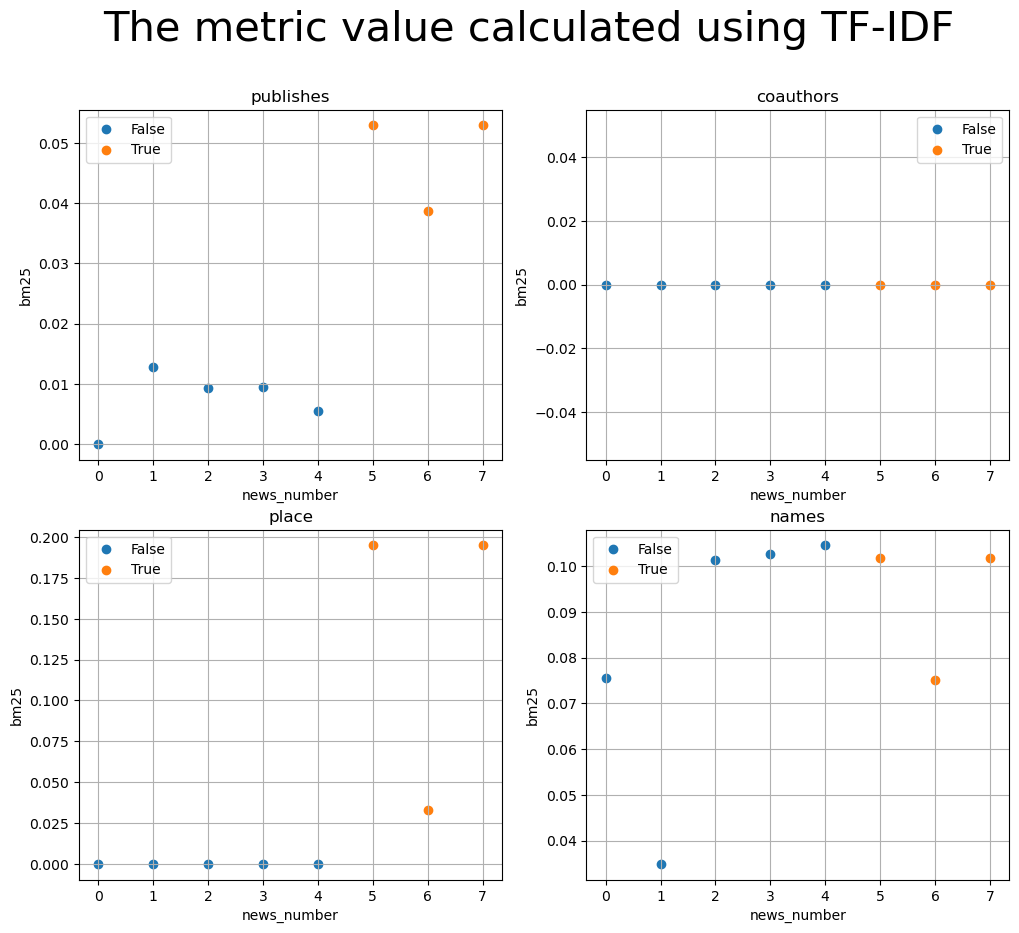

In [88]:
x_range = np.arange(0, len(corpus), 1)

for ind, i in enumerate(relevant):
    if i == 1:
        break
f_len = ind

fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=2)

ax[0,0].set_ylabel('bm25')
ax[0,0].set_xlabel('news_number')
ax[0,0].scatter(x_range[:f_len], tf[0][:f_len], c='#1f77b4').set_label('False')
ax[0,0].scatter(x_range[f_len:], tf[0][f_len:], c='#ff7f0e').set_label('True')
ax[0,0].set_title('publishes')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].set_ylabel('bm25')
ax[1,0].set_xlabel('news_number')
ax[1,0].scatter(x_range[:f_len], tf[1][:f_len], c='#1f77b4').set_label('False')
ax[1,0].scatter(x_range[f_len:], tf[1][f_len:], c='#ff7f0e').set_label('True')
ax[1,0].set_title('place')
ax[1,0].grid()
ax[1,0].legend()

ax[0,1].set_ylabel('bm25')
ax[0,1].set_xlabel('news_number')
ax[0,1].scatter(x_range[:f_len], tf[2][:f_len], c='#1f77b4').set_label('False')
ax[0,1].scatter(x_range[f_len:], tf[2][f_len:], c='#ff7f0e').set_label('True')
ax[0,1].set_title('coauthors')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].set_ylabel('bm25')
ax[1,1].set_xlabel('news_number')
ax[1,1].scatter(x_range[:f_len], tf[3][:f_len], c='#1f77b4').set_label('False')
ax[1,1].scatter(x_range[f_len:], tf[3][f_len:], c='#ff7f0e').set_label('True')
ax[1,1].set_title('names')
ax[1,1].grid()
ax[1,1].legend()

fig.suptitle('The metric value calculated using TF-IDF', fontsize=30)
# plt.show()
plt.savefig('tfidf.png')

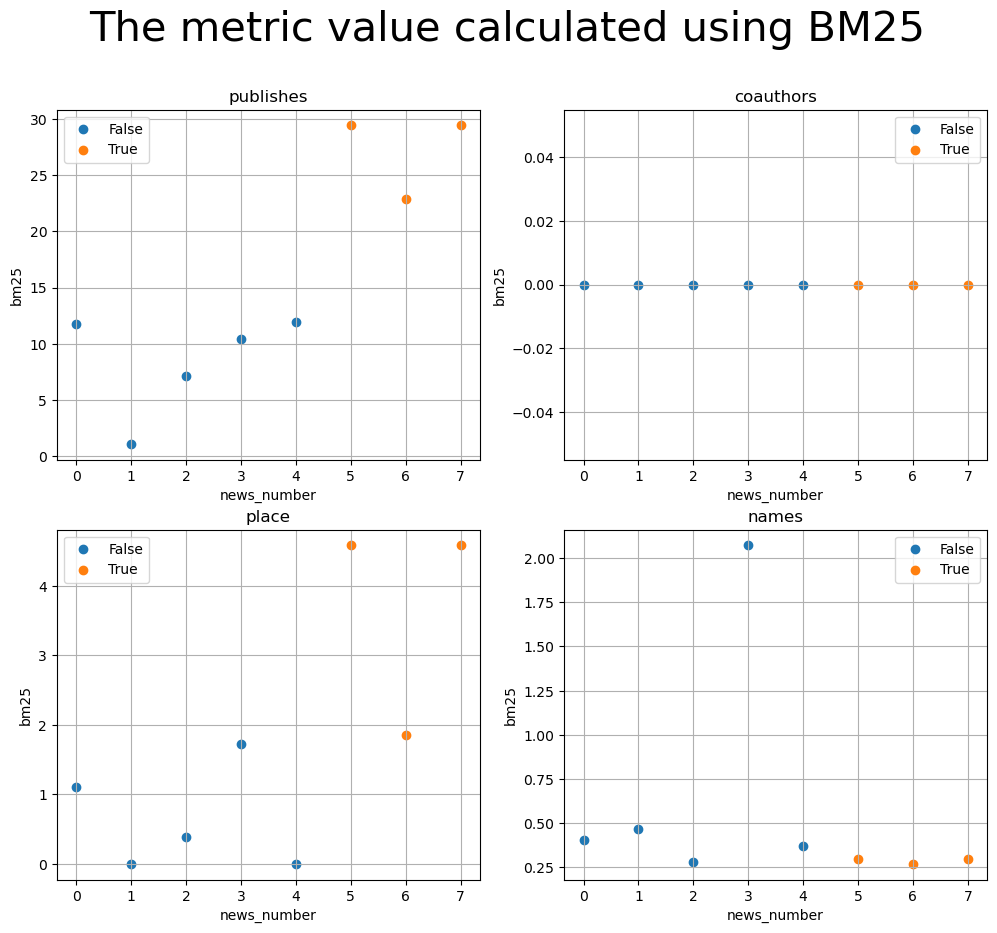

In [89]:
tt = pd.DataFrame(np.array(bm25_score).T)
tt['relevant'] = pd.Series(relevant, index=tt.index)
tt['cite'] = pd.Series(actual_news, index=tt.index)

x_range = np.arange(0, len(corpus), 1)

for ind, i in enumerate(relevant):
    if i == 1:
        break
f_len = ind

fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=2)

ax[0,0].set_ylabel('bm25')
ax[0,0].set_xlabel('news_number')
ax[0,0].scatter(x_range[:f_len], tt[0][:f_len], c='#1f77b4').set_label('False')
ax[0,0].scatter(x_range[f_len:], tt[0][f_len:], c='#ff7f0e').set_label('True')
ax[0,0].set_title('publishes')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].set_ylabel('bm25')
ax[1,0].set_xlabel('news_number')
ax[1,0].scatter(x_range[:f_len], tt[1][:f_len], c='#1f77b4').set_label('False')
ax[1,0].scatter(x_range[f_len:], tt[1][f_len:], c='#ff7f0e').set_label('True')
ax[1,0].set_title('place')
ax[1,0].grid()
ax[1,0].legend()

ax[0,1].set_ylabel('bm25')
ax[0,1].set_xlabel('news_number')
ax[0,1].scatter(x_range[:f_len], tt[2][:f_len], c='#1f77b4').set_label('False')
ax[0,1].scatter(x_range[f_len:], tt[2][f_len:], c='#ff7f0e').set_label('True')
ax[0,1].set_title('coauthors')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].set_ylabel('bm25')
ax[1,1].set_xlabel('news_number')
ax[1,1].scatter(x_range[:f_len], tt[3][:f_len], c='#1f77b4').set_label('False')
ax[1,1].scatter(x_range[f_len:], tt[3][f_len:], c='#ff7f0e').set_label('True')
ax[1,1].set_title('names')
ax[1,1].grid()
ax[1,1].legend()

fig.suptitle('The metric value calculated using BM25', fontsize=30)
# plt.show()
plt.savefig('bm25.png')